## Setup

In [1]:
import MEArec as mr
import numpy as np
import scipy.optimize
import os
import sys
import re
import ast
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from collections import defaultdict
from joblib import Parallel, delayed

import spikeinterface as si
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
import spikeinterface.comparison as scomp
import spikeinterface.curation as scu

sys.path.append('src')
from src.util_eval import *
from src.util_loc import *

In [2]:
# Overall parameters
mearec_seeds = [42, 43, 44, 45, 46]
dead_indices_seeds = [42, 43, 44, 45, 46]
run_id = f'20241226'
sorter_name = 'mountainsort4'
days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
        'D10','D11','D12','D13','D14','D15','D16','D17','D18','D19',
        'D20','D21','D22','D23','D24']
methods = ['center_of_mass', 'monopolar_triangulation', 'grid_convolution']
stable_days = 1
dead_electrodes_per_day = 1
gt_toggle = 0 # if 0, use ground truth data as experimental data
correct_radius = 30 # microns

# MEArec parameters
mearec_probe = 'SqMEA-5-30'
num_channels = 25
recgen_duration = 600
mearec_noise_level = 1
output_mearec = f'output/{run_id}'

## Figure Charts - Across Seeds

In [3]:
def get_run_params(mearec_seed, dead_indices_seed):

    seed_folder = f'{output_mearec}_{mearec_seed}/seed_{dead_indices_seed}'
    
    # Recording data
    recording_mearec = se.MEArecRecordingExtractor(f'{output_mearec}_{mearec_seed}/seed_42/D0/recording.h5')
    probe = recording_mearec.get_probe()

    # Waveform extractor data
    wes_gt = []
    for day_i, day in enumerate(days):
        wes_gt.append(si.load_waveforms(f'{output_mearec}_{mearec_seed}/seed_42/{day}/waveforms_gt', with_recording=False))

    # Dead indices
    with open(f'{seed_folder}/dead_indices.pkl', 'rb') as f:
        dead_indices = pickle.load(f)

    # Load tempgen and recgen
    tempgen = mr.load_templates(f'{seed_folder}/templates.h5')
    recgen = mr.load_recordings(f'{seed_folder}/D0/recording.h5')

    # Load templates
    with open(f'{seed_folder}/loc_est_units/loc_est_units.pkl', 'rb') as f:
        loc_est_units = pickle.load(f)
    with open(f'{seed_folder}/loc_est_units/time_units.pkl', 'rb') as f:
        time_units = pickle.load(f)

    # Load spikes
    with open(f'{seed_folder}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
        loc_est_spikes = pickle.load(f)
    with open(f'{seed_folder}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
        time_spikes = pickle.load(f)
    
    electrode_loc = recording_mearec.get_channel_locations()
    unit_loc_true = recgen.template_locations
    
    return wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true

In [4]:
fig_days = ['D0', 'D2', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'D16', 'D18', 'D20', 'D22', 'D24']

fig_days_label = []
for day_i in range(len(fig_days)):
    fig_days_label.append(dead_electrodes_per_day*days.index(fig_days[day_i])/num_channels)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig_method_label = ['CoM', 'MT', 'GC']
os.makedirs(f'{output_mearec}', exist_ok=True)

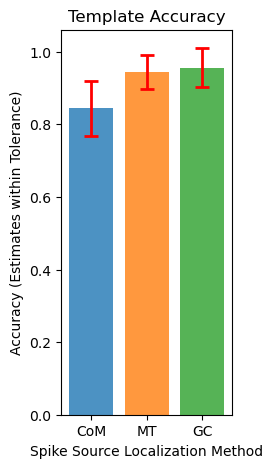

In [5]:
"""Figure 2: Template Accuracy with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_right = 0
        n_wrong = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
            
            unit_loc_est = loc_est_units[method]
            for unit_idx, unit_id in enumerate(we.unit_ids):
                if np.linalg.norm(unit_loc_est[0][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                    n_right += 1
                else:
                    n_wrong += 1
            
        loss_method.append(n_right / (n_right + n_wrong))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))    

# Create plot
error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')

fig.savefig(f'{output_mearec}/2A_1.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


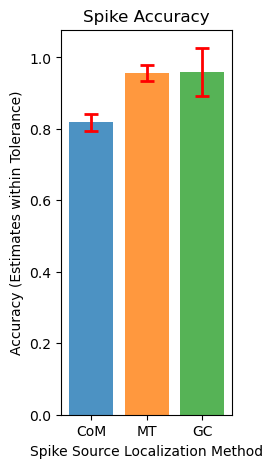

In [6]:
"""Figure 2: Spike Accuracy with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    print(method)
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_right = 0
        n_wrong = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
                        
            unit_loc_est = loc_est_spikes[method][days[we_i]]
            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                n_right += unit_n_right
                n_wrong += unit_n_wrong

        loss_method.append(n_right / (n_right + n_wrong))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))    

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(['CoM','MT','GC'], loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
fig.savefig(f'{output_mearec}/2B_1.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


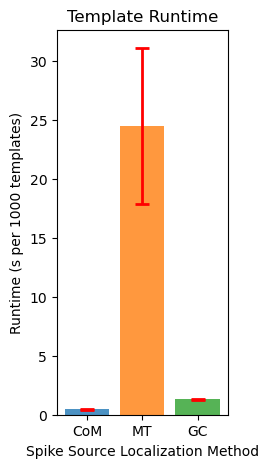

In [30]:
"""Figure 2: Template Runtime with No Dead Electrodes"""

time_mean = []
time_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    print(method)
    
    time_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_templates = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            time_method[mearec_seed_i] += time_units[method]
            n_templates += loc_est_units[method][0].shape[0] * len(loc_est_units[method])
        time_method[mearec_seed_i] = 1000 * time_method[mearec_seed_i] / n_templates
    
    time_mean.append(np.mean(time_method))
    time_std.append(np.std(time_method))

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, time_mean, yerr=time_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template Runtime')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Runtime (s per 1000 templates)')
fig.savefig(f'{output_mearec}/2A_2.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


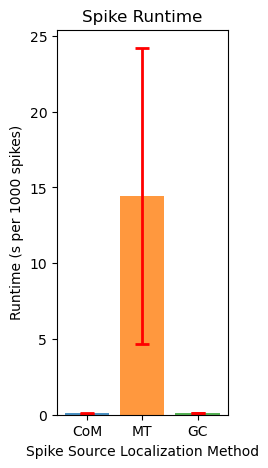

In [32]:
"""Figure 2: Spike Runtime with No Dead Electrodes"""

time_mean = []
time_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))
for method_i, method in enumerate(methods):
    print(method)
    
    time_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        n_spikes = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            time_method[mearec_seed_i] += time_spikes[method][days[0]]
            for value in loc_est_spikes[method][days[0]][0].values():
                n_spikes += value.shape[0]
                
        time_method[mearec_seed_i] = 1000 * time_method[mearec_seed_i] / n_spikes
    
    time_mean.append(np.mean(time_method))
    time_std.append(np.std(time_method))

error_kw = {'ecolor': 'red', 'capsize': 5, 'capthick': 2, 'elinewidth': 2}
ax.bar(fig_method_label, time_mean, yerr=time_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike Runtime')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Runtime (s per 1000 spikes)')
fig.savefig(f'{output_mearec}/2B_2.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


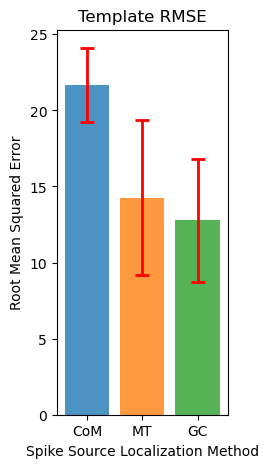

In [33]:
"""Figure 2: Template RMSE with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method_i, method in enumerate(methods):
    print(method)
    
    loss_method = np.zeros(len(mearec_seeds))
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_units[method]
            loss_method[mearec_seed_i] += get_loss_rmse_gt(unit_loc_true, unit_loc_est[we_i]) / len(dead_indices_seeds)
    
    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))        

ax.bar(['CoM','MT','GC'], loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Template RMSE')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Root Mean Squared Error')
fig.savefig(f'{output_mearec}/2A_3.svg', format='svg', bbox_inches='tight')

center_of_mass
monopolar_triangulation
grid_convolution


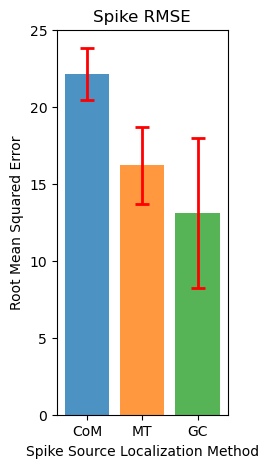

In [34]:
"""Figure 2: Spike RMSE with No Dead Electrodes"""

loss_mean = []
loss_std = []

fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    print(method)
    
    loss_method = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
    
        day_SE = 0
        day_spikes = 0
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):        
            
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]
            
            unit_loc_est = loc_est_spikes[method][days[we_i]]

            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                unit_SE, unit_spikes = get_loss_RMSE_spikes_2(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
                day_SE += unit_SE
                day_spikes += unit_spikes
        
        loss_method.append(np.sqrt(day_SE/day_spikes))

    loss_mean.append(np.mean(loss_method))
    loss_std.append(np.std(loss_method))

ax.bar(['CoM','MT','GC'], loss_mean, yerr=loss_std, color=colors, alpha=0.8, error_kw=error_kw)
ax.title.set_text(f'Spike RMSE')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Root Mean Squared Error')
fig.savefig(f'{output_mearec}/2B_3.svg', format='svg', bbox_inches='tight')

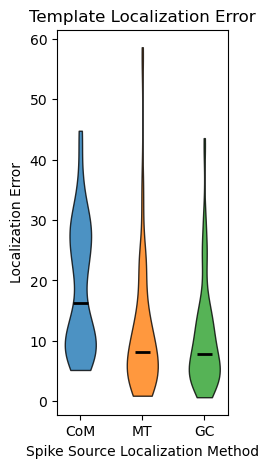

In [35]:
"""Figure 2: Template RMSE Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method_i, method in enumerate(methods):

    rmse = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_units[method]
            diff = unit_loc_true[:, 1:] - unit_loc_est[we_i][:, :2]
            rmse.extend(np.sqrt(np.sum(diff**2, axis=1)))
        
    loss.append(rmse)

# Create the violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize the violin plot to resemble seaborn's default style
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Adding the median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['CoM', 'MT', 'GC'])

ax.title.set_text('Template Localization Error')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Localization Error')

fig.savefig(f'{output_mearec}/2A_4.svg', format='svg', bbox_inches='tight')

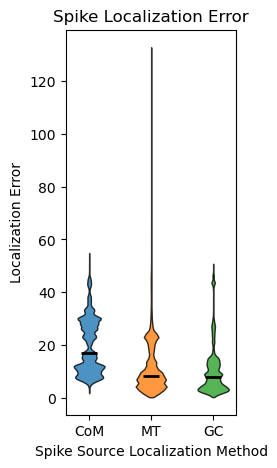

In [36]:
"""Figure 2: Spike RMSE Violin Plot with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    
for method in methods:

    day_err = []
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            we_i = 0
            we = wes_gt[0]

            unit_loc_est = loc_est_spikes[method][days[we_i]]
            
            # Calculate loss
            for unit_idx, unit_id in enumerate(we.unit_ids):                
                unit_err = get_loss_RMSE_spikes_ind(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
                day_err.extend(unit_err)
            
    day_err.sort()
    day_err = day_err[500:-500]
    loss.append(day_err)

# Create the violin plot
parts = ax.violinplot(loss, showmeans=False, showmedians=True, showextrema=False)

# Customize the violin plot to resemble seaborn's default style
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

# Adding the median line
parts['cmedians'].set_color('black')
parts['cmedians'].set_linewidth(2)

# Set the x-ticks to correspond to each method
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['CoM', 'MT', 'GC'])

ax.title.set_text('Spike Localization Error')
ax.set_xlabel('Spike Source Localization Method')
ax.set_ylabel('Localization Error')

fig.savefig(f'{output_mearec}/2B_4.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


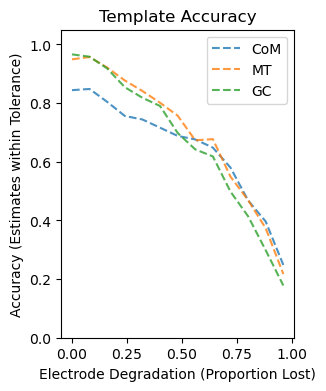

In [37]:
"""Figure 3A: Template Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):
        print(day)
        
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                n_right = 0
                n_wrong = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_units[method]
                    for unit_idx, unit_id in enumerate(we.unit_ids):
                        if np.linalg.norm(unit_loc_est[we_i][unit_idx, :2] - recgen.template_locations[unit_idx, 1:]) < correct_radius:
                            n_right += 1
                        else:
                            n_wrong += 1
                    
                loss_day.append(n_right / (n_right + n_wrong))

            loss_mean.append(np.mean(loss_day))

    # Create plot
    loss_mean = np.array(loss_mean)
    method_jit = method_i * 0.005
    ax.plot(fig_days_label, loss_mean + method_jit, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3A_1.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


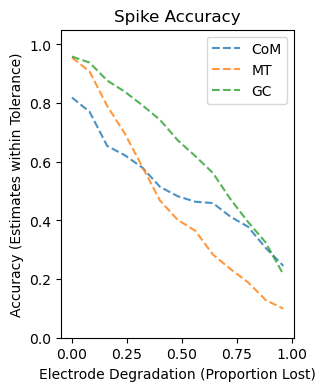

In [38]:
"""Figure 3A: Spike Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
            
                n_right = 0
                n_wrong = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]

                    unit_loc_est = loc_est_spikes[method][days[we_i]]
                    
                    # Calculate loss
                    for unit_idx, unit_id in enumerate(we.unit_ids):
                        unit_n_right, unit_n_wrong = get_loss_acc_spikes_2(recgen.template_locations[unit_idx], unit_loc_est[0][unit_id], correct_radius)
                        n_right += unit_n_right
                        n_wrong += unit_n_wrong

                loss_day.append(n_right / (n_right + n_wrong))

            loss_mean.append(np.mean(loss_day))

    # Create plot
    ax.plot(fig_days_label, loss_mean, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_mearec}/3B_1.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


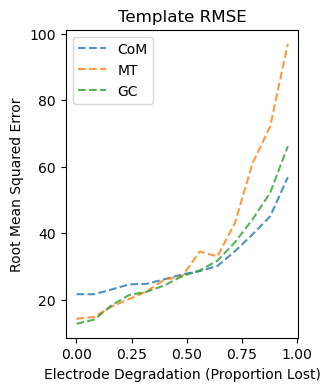

In [39]:
"""Figure 3A: Template RMSE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            loss_day = 0
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                    
                    unit_loc_est = loc_est_units[method]
                    loss_day += get_loss_rmse_gt(unit_loc_true, unit_loc_est[we_i])
            
            loss_mean.append(loss_day / (len(dead_indices_seeds) * len(mearec_seeds)))

    # Create plot
    loss_mean = np.array(loss_mean)
    ax.plot(fig_days_label, loss_mean, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template RMSE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

fig.savefig(f'{output_mearec}/3A_2.svg', format='svg', bbox_inches='tight')

D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24
D0
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
D16
D17
D18
D19
D20
D21
D22
D23
D24


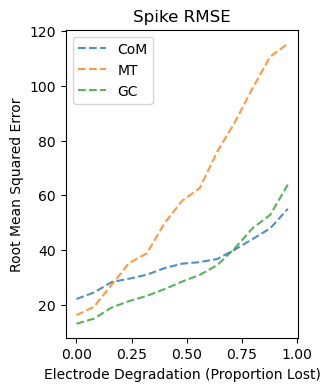

In [40]:
"""Figure 3B: Spike RMSE v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    loss_mean = []
    for day_i, day in enumerate(days):

        print(day)
        if day in fig_days:

            loss_day = []
            for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):

                day_SE = 0
                day_spikes = 0
                for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
                    
                    wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
                    we_i = day_i
                    we = wes_gt[we_i]
                
                    unit_loc_est = loc_est_spikes[method][day]
                    
                    # Calculate loss
                    for unit_idx, unit_id in enumerate(we.unit_ids):                
                        unit_SE, unit_spikes = get_loss_RMSE_spikes_2(unit_loc_true[unit_idx], unit_loc_est[0][unit_id])
                        day_SE += unit_SE
                        day_spikes += unit_spikes
            
                loss_day.append(np.sqrt(day_SE/day_spikes))
            
            loss_mean.append(np.mean(loss_day))

    # Create plot
    ax.plot(fig_days_label, loss_mean, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike RMSE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

fig.savefig(f'{output_mearec}/3B_2.svg', format='svg', bbox_inches='tight')

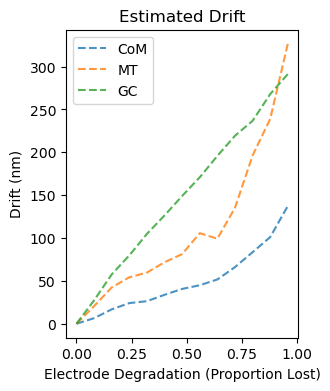

In [41]:
"""Figure 3A: Template Drift"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_drift = {}

for method in methods:
    estimated_drift[method] = np.zeros(len(fig_days))
    
    for mearec_seed_i, mearec_seed in enumerate(mearec_seeds):
        
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):    
            wes_gt, dead_indices, tempgen, recgen, loc_est_units, time_units, loc_est_spikes, time_spikes, electrode_loc, unit_loc_true = get_run_params(mearec_seed, dead_indices_seed)
            
            loc_est_unit_0 = loc_est_units[method][0]
            
            for we_i, we in enumerate(wes_gt):
                if days[we_i] in fig_days:
                    loc_est_unit = loc_est_units[method][we_i]
                    drift = np.mean(np.linalg.norm(loc_est_unit - loc_est_unit_0))
                    day_index = fig_days.index(days[we_i])
                    estimated_drift[method][day_index] += drift / (len(dead_indices_seeds) * len(mearec_seeds))
                        
# Create a line plot of the drift for all three localization methods
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_drift[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text('Estimated Drift')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Drift (nm)')
ax.legend()

fig.savefig(f'{output_mearec}/3A_3.svg', format='svg', bbox_inches='tight')

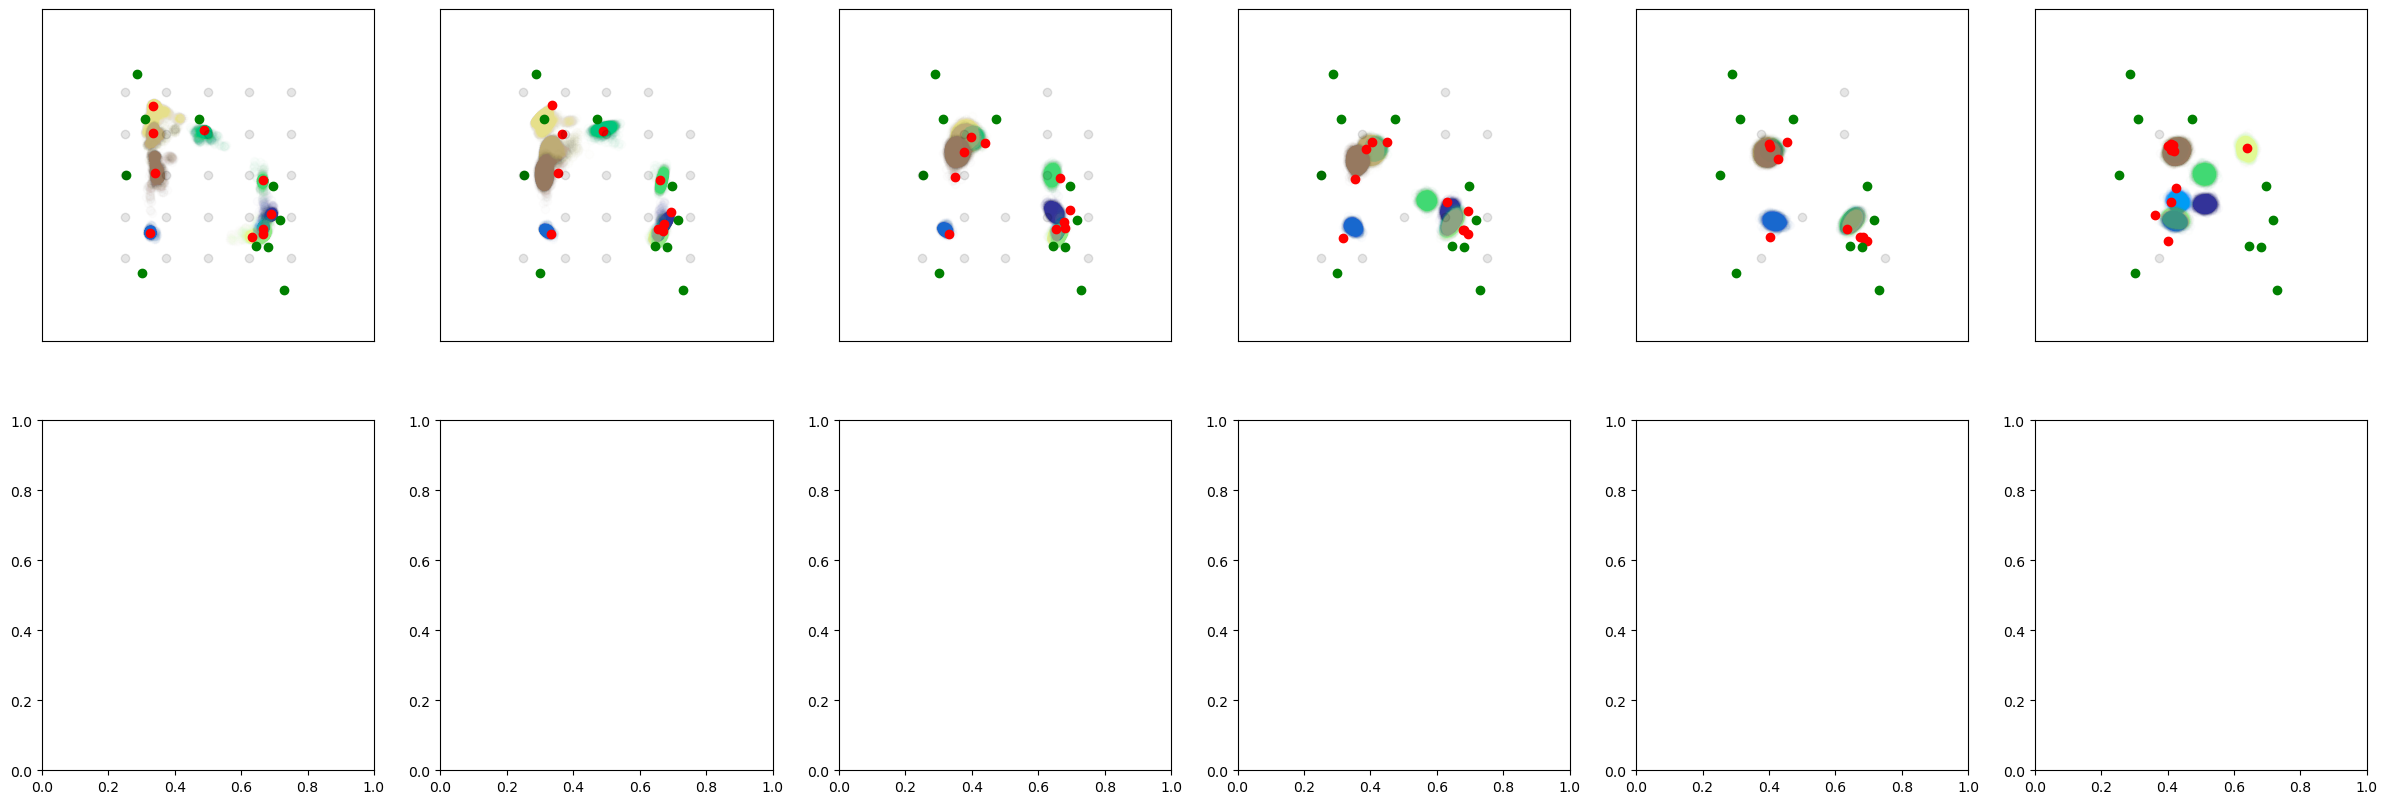

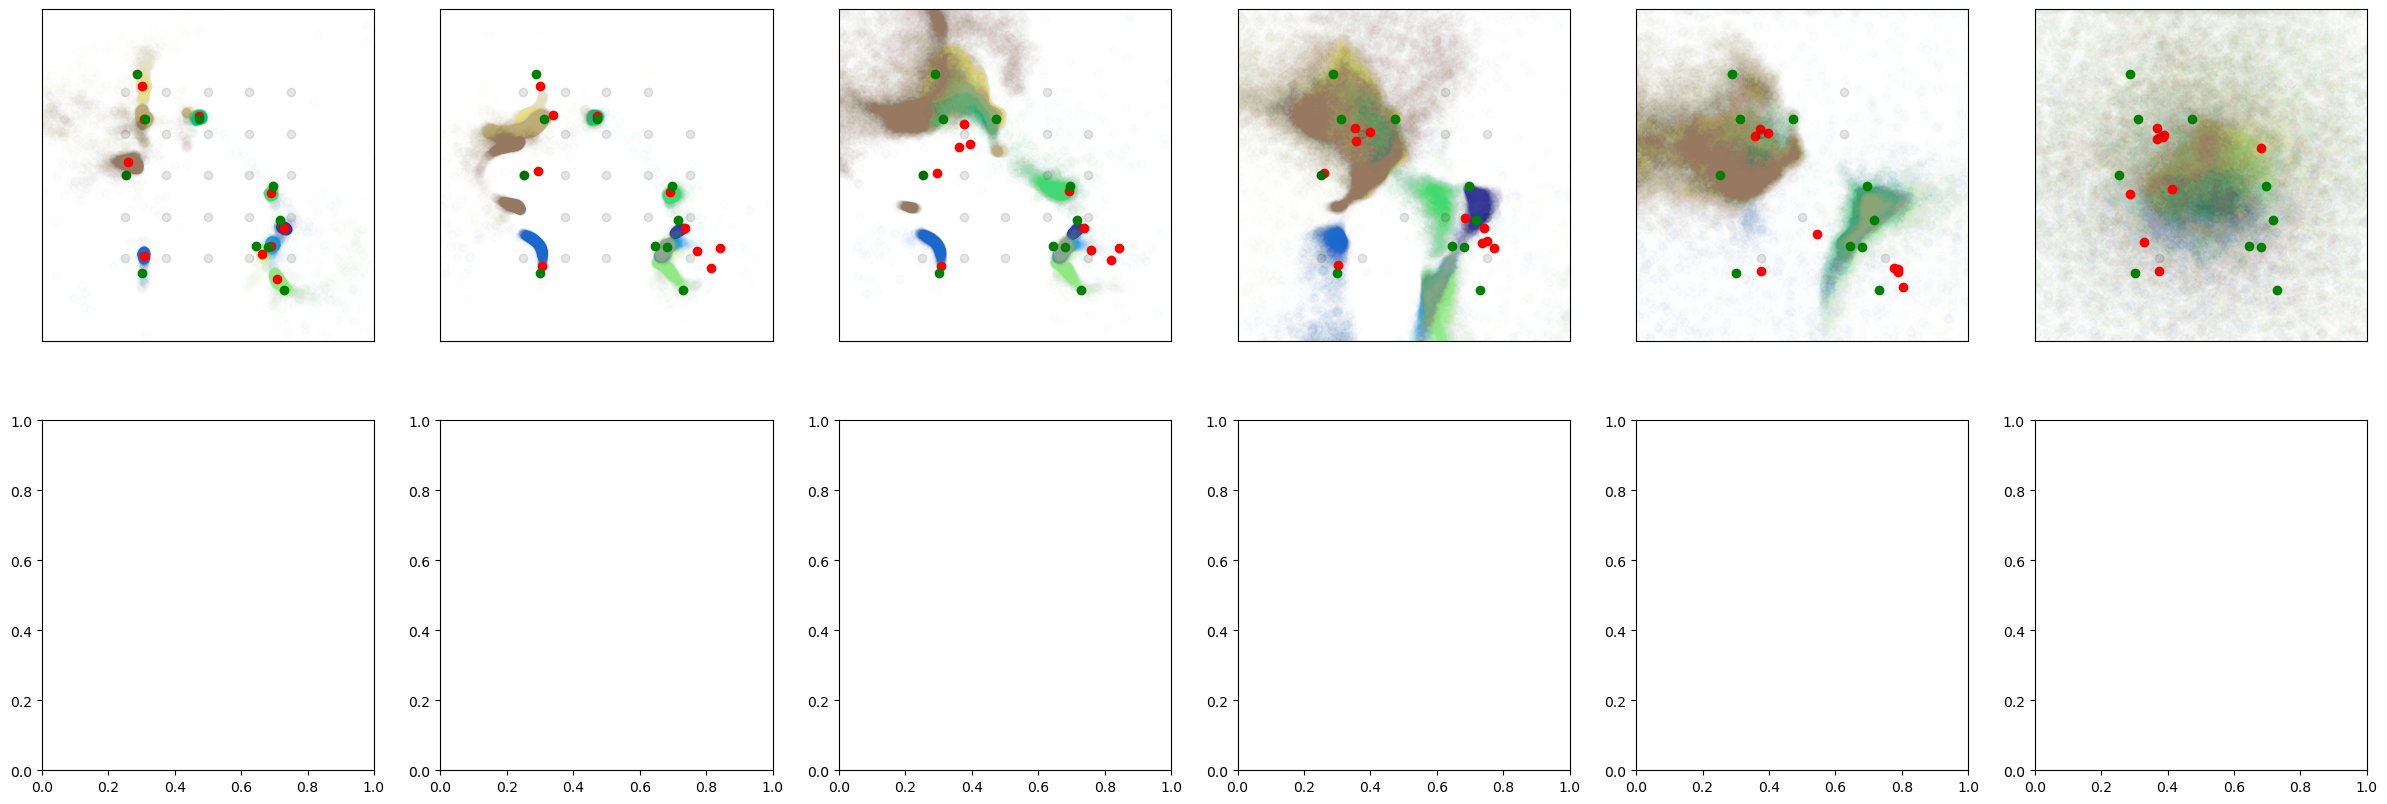

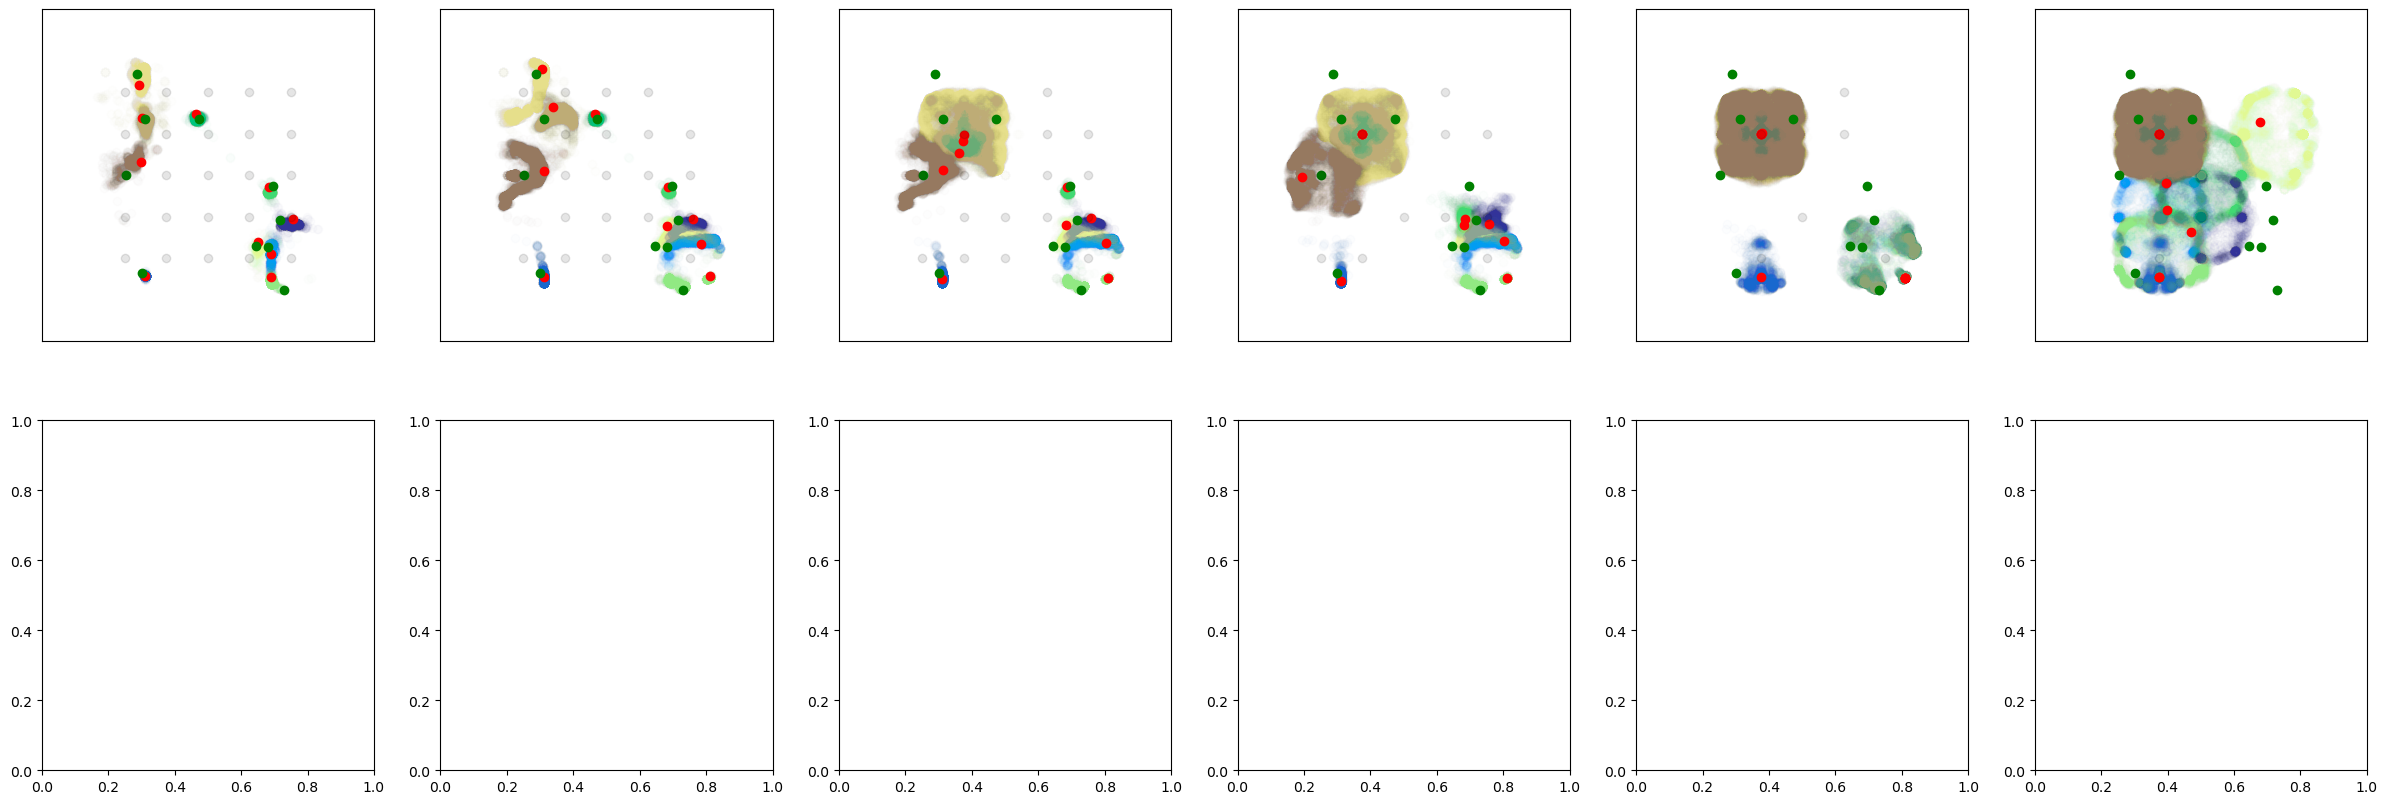

In [18]:
fig_days_2 = ['D0', 'D5', 'D10', 'D15', 'D20', 'D24']

for method in methods:

    range_x = electrode_loc[:, 0].max() - electrode_loc[:, 0].min()
    range_y = electrode_loc[:, 1].max() - electrode_loc[:, 1].min()
    range_A = min(range_x, range_y)

    col_num = 6
    row_num = max(int(np.ceil(len(fig_days_2)/col_num)),2)
    fig, axs = plt.subplots(row_num, col_num, figsize=(5*col_num, 5*row_num))  

    for we_i, we in enumerate(wes_gt):
        
        if days[we_i] in fig_days_2:

            loc_est_unit = loc_est_units[method][we_i]
            loc_est_spike = loc_est_spikes[method][days[we_i]]
            
            dead_electrodes = dead_indices[we_i]
            live_electrodes = np.delete(np.arange(electrode_loc.shape[0]), dead_electrodes)

            # Create plot
            row_gt = np.where(np.array(fig_days_2) == days[we_i])[0][0] // col_num
            col_gt = np.where(np.array(fig_days_2) == days[we_i])[0][0] % col_num

            for unit_idx, unit_id in enumerate(we.unit_ids):
                unit_loc_est_temp = loc_est_spike[0][unit_id]
                unit_loc_est_temp = np.array(unit_loc_est_temp.tolist())
                axs[row_gt, col_gt].scatter(unit_loc_est_temp[:, 0], unit_loc_est_temp[:, 1], color=plt.get_cmap('terrain')(unit_idx*20), alpha=0.01, label='Estimated Spikes')

            axs[row_gt, col_gt].scatter(loc_est_unit[:, 0], loc_est_unit[:, 1], color='red', label='Estimated Templates')
            axs[row_gt, col_gt].scatter(unit_loc_true[:, 1], unit_loc_true[:, 2], color='green', label='True Neurons')
            axs[row_gt, col_gt].scatter(electrode_loc[live_electrodes, 0], electrode_loc[live_electrodes, 1], color=[0, 0, 0], alpha=0.1 , label='Electrodes')
            axs[row_gt, col_gt].set_xlim([electrode_loc[:, 0].min() - range_A*0.5, electrode_loc[:, 0].max() + range_A*0.5])
            axs[row_gt, col_gt].set_ylim([electrode_loc[:, 1].min() - range_A*0.5, electrode_loc[:, 1].max() + range_A*0.5])
            axs[row_gt, col_gt].get_xaxis().set_visible(False)
            axs[row_gt, col_gt].get_yaxis().set_visible(False)
            axs[row_gt, col_gt].set_aspect('equal')
    
    fig.savefig(f'{output_mearec}/3C_{method}.svg', format='svg', bbox_inches='tight')


# Re-import libraries

In [31]:
import importlib
import src

importlib.reload(src.util_eval)
from src.util_eval import *